In [2]:
import skimage
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score, train_test_split

In [51]:
from skimage import io
from skimage import transform, feature
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import sys
import os.path

In [5]:
from pyimage.pipeline import ImagePipeline

# Basic read/transform

In [107]:
os.listdir('image_test') 

['.DS_Store',
 'dining_chair',
 'dining_table',
 'futon_ANDO1714_3.jpg',
 'futon_BYSN1003_1.jpg',
 'futon_BYSN1032_0.jpg',
 'nightstand_ACBP1054_0.jpg',
 'nightstand_ANDO1522_1.jpg',
 'nightstand_ATF1862_1.jpg',
 'nightstand_ATF1863_0.jpg']

In [44]:
ns = skimage.io.imread('image_test/nightstand_ANDO1522_1.jpg')
ns.shape

(400, 400, 3)

In [45]:
ft = skimage.io.imread('image_test/futon_BYSN1003_1.jpg')
ft.shape

(400, 400, 3)

In [46]:
dc = skimage.io.imread('image_test/dining_chair/dining_chair_AAM1013_0.jpg')

In [47]:
print ns[0][0]
print ft[0][0]

[255 255 255]
[255 255 255]


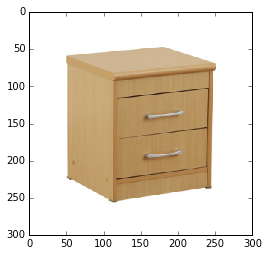

In [61]:
ns_s = transform.resize(ns, (300,300,3))
skimage.io.imshow(ns_s)

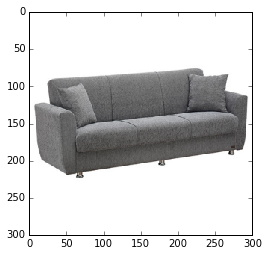

In [62]:
ft_s = transform.resize(ft, (300,300,3))
skimage.io.imshow(ft_s)

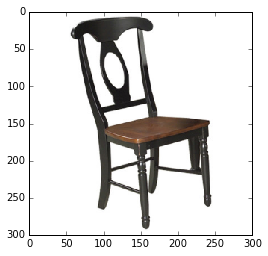

In [50]:
dc_s = transform.resize(dc, (300,300,3))
skimage.io.imshow(dc_s)

In [51]:
print ns_s[0][0]
print ft_s[0][0]

[ 1.  1.  1.]
[ 1.  1.  1.]


In [63]:
ns_gray = skimage.color.rgb2gray(ns_s)
ft_gray = skimage.color.rgb2gray(ft_s)
dc_gray = skimage.color.rgb2gray(dc_s)

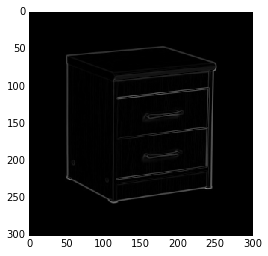

In [64]:
ns_sobal = skimage.filters.sobel(ns_gray)
skimage.io.imshow(ns_sobal)

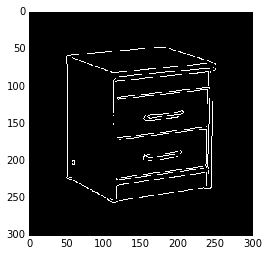

In [65]:
ns_canny = feature.canny(ns_gray, sigma=1)
skimage.io.imshow(ns_canny)

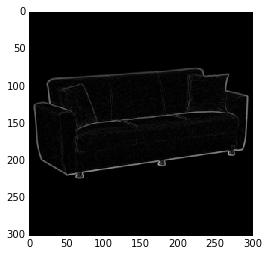

In [66]:
ft_sobal = skimage.filters.sobel(ft_gray)
skimage.io.imshow(ft_sobal)

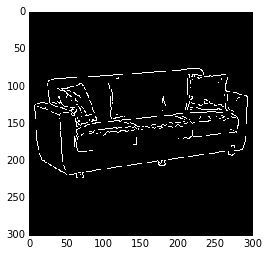

In [67]:
ft_canny = feature.canny(ft_gray, sigma=1)
skimage.io.imshow(ft_canny)

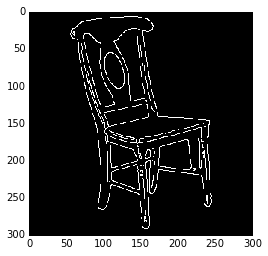

In [68]:
dc_canny = feature.canny(dc_gray, sigma=1)
skimage.io.imshow(dc_canny)

# Get dominant colors

In [80]:
def show_domi_color(image, n_clusters=3):
    nrow, ncol, depth = image.shape 
    lst_of_pixels = [image[irow][icol] for irow in range(nrow) for icol in range(ncol)]
    kmean = KMeans(n_clusters=n_clusters)
    kmean.fit_transform(lst_of_pixels)
    domi_colors = kmean.cluster_centers_ 
    domi_colors = domi_colors.reshape((1,n_clusters,3))
    skimage.io.imshow(domi_colors)
    return domi_colors

array([[[ 0.99545379,  0.99534742,  0.99499355],
        [ 0.260858  ,  0.23378773,  0.2103252 ]]])

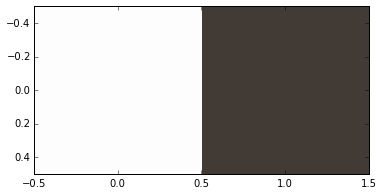

In [90]:
show_domi_color(dc_s,2)

array([[[ 0.41287307,  0.4111672 ,  0.4123232 ],
        [ 0.99697897,  0.99698345,  0.99703543]]])

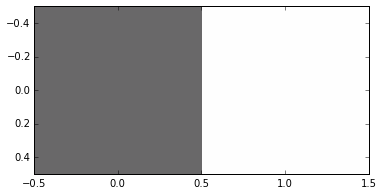

In [91]:
show_domi_color(ft_s,2)

array([[[ 0.99903168,  0.99878974,  0.99828544],
        [ 0.72569777,  0.59101235,  0.40156324]]])

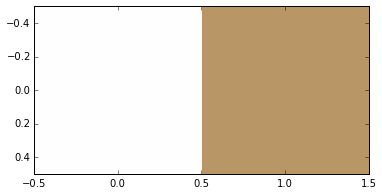

In [92]:
show_domi_color(ns_s,2)

array([[[ 0.32789879,  0.21762493,  0.14094831],
        [ 0.9122282 ,  0.83985693,  0.73882488]]])

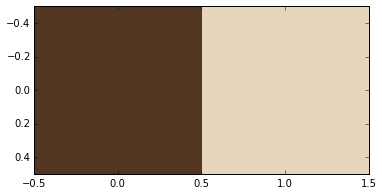

In [89]:
dc2 = skimage.io.imread('image_test/dining_chair/dining_chair_AAM1013_4.jpg')
dc2_s = transform.resize(dc2, (300,300,3))
show_domi_color(dc2_s,2)

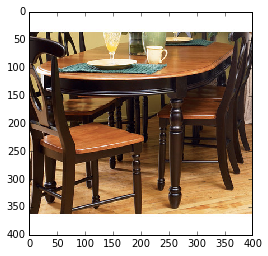

In [86]:
skimage.io.imshow(dc2)

array([[[ 0.91982567,  0.90630636,  0.90144896],
        [ 0.51153655,  0.44642687,  0.3575924 ]]])

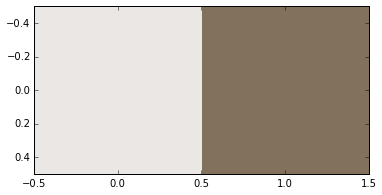

In [88]:
dc3 = skimage.io.imread('image_test/dining_chair/dining_chair_AAM1013_10.jpg')
dc3_s = transform.resize(dc3, (300,300,3))
show_domi_color(dc3_s,2)

array([[[ 0.61830123,  0.56360316,  0.49816156],
        [ 0.99590315,  0.99533759,  0.99440849]]])

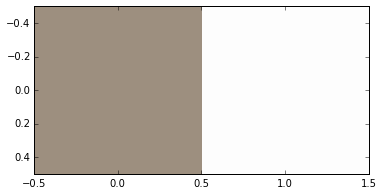

In [93]:
ns2 = skimage.io.imread('image_test/nightstand_ATF1863_0.jpg')
ns2_s = transform.resize(ns2, (300,300,3))
show_domi_color(ns2_s,2)

array([[[ 0.84835724,  0.8357177 ,  0.77182149],
        [ 0.64594748,  0.62315387,  0.40829908]]])

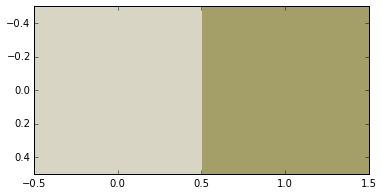

In [99]:
dc4 = skimage.io.imread('image_test/dining_chair/dining_chair_ADEC1338_4.jpg')
dc4_s = transform.resize(dc4, (300,300,3))
show_domi_color(dc4_s,2)

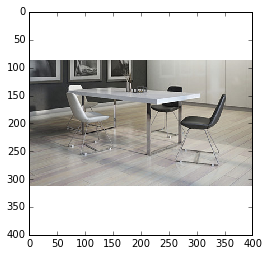

In [110]:
skimage.io.imshow(dt)

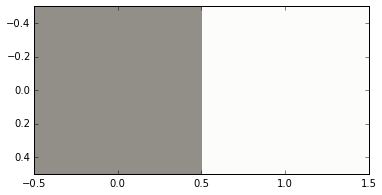

In [114]:
dt = skimage.io.imread('image_test/dining_table/dining_table_AEON1147_1.jpg')
dt_s = transform.resize(dt, (300,300,3))
domi_color = show_domi_color(dt_s,2)

In [117]:
domi_color[0]

array([[ 0.57300862,  0.56091193,  0.5370785 ],
       [ 0.98825312,  0.98839057,  0.98751723]])

# Clustering by dominant colors

### One way to tease out photos with white backgroud: find 2 dominant colors and one of them is white([x,x,x], all x>0.985)

## test sofa images:
* dir
* get dominant color for the furniture
* cluster

In [6]:
sofa_paths = os.listdir('image_test/sofa') 
len(sofa_paths)

112

In [62]:
chair_paths = os.listdir('image_test/dining_chair')
if chair_paths[0] == '.DS_Store':
    chair_paths = chair_paths[1:]
len(chair_paths)

1072

In [63]:
def get_domi_color_for_photo_with_white_background(paths, category):
    '''
    INPUT:
        paths: list, paths of image files
        category: string
    For all files in paths, 
        tease out photos without a clear white background and save those into 'background' folder.
    For those with white background, save then to 'white' folder.
    OUTPUT:
        domi_color_dict: dictionary, key=path and value=dominant color(just one).
    '''
    domi_color_dict = {}
    
    for path in paths:
        image = skimage.io.imread('image_test/' + category + '/' + path)
        image = transform.resize(image, (300,300,3))

        nrow, ncol, depth = image.shape 
        lst_of_pixels = [image[irow][icol] for irow in range(nrow) for icol in range(ncol)]

        """Remove photos without clean white background:
            If one of the two dominant color is white, 
            when the photo has a clean white background and flag=True."""

        kmean1 = KMeans(n_clusters=3)
        kmean1.fit_transform(lst_of_pixels)
        domi_colors_all = kmean1.cluster_centers_ 
        white_color_arr = np.array([0.985, 0.985, 0.985])
        

        flag = False
        for color in domi_colors_all:
            if np.mean(color>white_color_arr) == 1:
                flag = True
            else:
                domi_color = color

        if not flag:    
            new_path = 'image_test_result/background/' + path
            skimage.io.imsave(new_path, image)
            continue
        else:
            new_path = 'image_test_result/white/' + path
            skimage.io.imsave(new_path, image)
            domi_color_dict[path] = domi_color 
        
    return domi_color_dict


In [64]:
domi_color_dict = get_domi_color_for_photo_with_white_background(chair_paths, 'dining_chair')

RuntimeError: invalid shape for coordinate array

In [61]:
len(domi_color_dict.keys())

44

In [43]:
def clustering_with_domi_color(domi_color_dict, category, n_clusters=6):
    '''
    INPUT: domi_color_dict:
            * key: path
            * value: dominant color (just one)
    
    Cluster by color & save files to different folders according to labels.
    
    OUTPUT: cluster_label_dict
            * key: path
            * value: cluster label
            color_centroids:
            * index: label 
            * value: centroid
    '''
    domi_color_values = domi_color_dict.values()
    
    domi_color_reverse_dict = {}
    for i, j in domi_color_dict.iteritems():
        domi_color_reverse_dict[tuple(j)] = i 
        
    km_color = KMeans(n_clusters=n_clusters)
    domi_colors_lables =km_color.fit_predict(domi_color_values)
    
    color_centroids = km_color.cluster_centers_
             
    cluster_label_dict = {}
    for i, j in enumerate(domi_color_values):
        label = domi_colors_lables[i]
        path = domi_color_reverse_dict[tuple(j)]
        cluster_label_dict[path] = label
        
        image = skimage.io.imread('image_test/' + category + '/' + path)
        new_path = 'image_test_result/' + str(label) + '/' + path
        skimage.io.imsave(new_path, image)
    
    return cluster_label_dict, color_centroids

In [44]:
cluster_label_dict, color_centroids = clustering_with_domi_color(domi_color_dict, 'dining_chair')

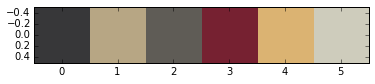

In [45]:
color_centroids = color_centroids.reshape((1,6,3))
skimage.io.imshow(color_centroids)

# Clustering by features:

In [20]:
image_pipe = ImagePipeline('image_test/')

In [22]:
image_pipe.read(sub_dirs=('dining_chair',))

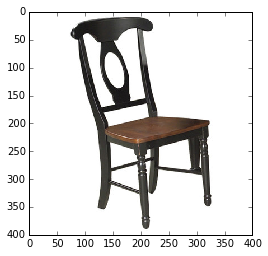

In [23]:
image_pipe.show('dining_chair', 0)

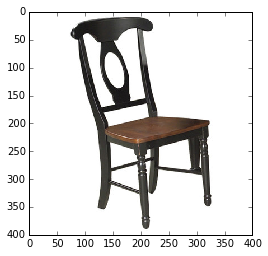

In [24]:
skimage.io.imshow(image_pipe.img_lst2[0][0])

In [25]:
image_pipe.resize((150,150,3))
image_pipe.transform(skimage.color.rgb2gray, {})
image_pipe.vectorize()
features = image_pipe.features

In [28]:
features.shape

(83, 22500)

In [36]:
chair_paths = os.listdir('image_test/dining_chair')
if chair_paths[0] == '.DS_Store':
    chair_paths = chair_paths[1:]
len(chair_paths)

83

In [37]:
feature_dict = {}
for i in xrange(len(chair_paths)):
    path = chair_paths[i]
    feature = features[i]
    feature_dict[path] = feature

In [46]:
def clustering_with_feature(feature_dict, n_clusters=6):
    '''
    INPUT: feature_dict:
            * key: path
            * value: feature
    
    Cluster by feature & save files to different folders according to labels.
    
    OUTPUT: cluster_label_dict
            * key: path
            * value: cluster label
            feature_centroids:
            * index: label 
            * value: centroid
    '''
    feature_values = feature_dict.values()
    
    feature_reverse_dict = {}
    for i, j in feature_dict.iteritems():
        feature_reverse_dict[tuple(j)] = i 
        
    km_feature = KMeans(n_clusters=n_clusters)
    features_lables =km_feature.fit_predict(feature_values)
    
    feature_centroids = km_feature.cluster_centers_
             
    cluster_label_dict = {}
    for i, j in enumerate(feature_values):
        label = features_lables[i]
        path = feature_reverse_dict[tuple(j)]
        cluster_label_dict[path] = label
        
        image = skimage.io.imread('image_test/dining_chair/' + path)
        new_path = 'image_test_result/features/' + str(label) + '/' + path
        skimage.io.imsave(new_path, image)
    
    return cluster_label_dict, feature_centroids

In [47]:
cluster_label_dict, feature_centroids = clustering_with_feature(feature_dict)

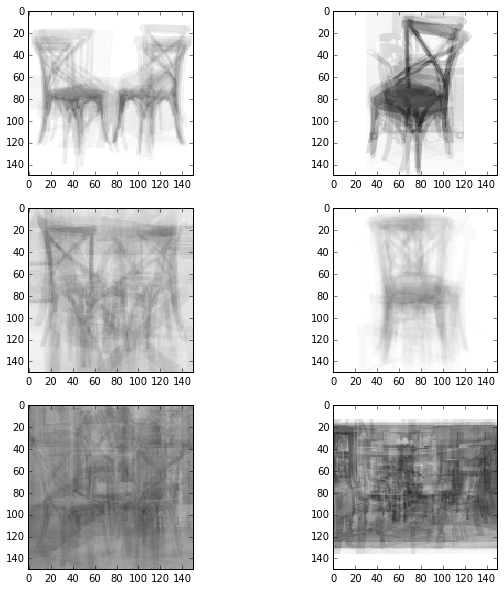

In [54]:
plt.figure(figsize = (10,10))
for i in range(6):
    plt.subplot(3,2,i)
    skimage.io.imshow(feature_centroids[i].reshape(150,150))